<a href="https://colab.research.google.com/github/guptavasu1213/glaucoma-diagnosis/blob/master/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

In [ ]:
%load_ext tensorboard
logs_base_dir = "drive/Shared drives/Capstone Summer 2020/Models/Unet_From_Scratch/runs"
os.makedirs(logs_base_dir, exist_ok=True)

In [ ]:
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim import lr_scheduler
from torch.utils.data import Dataset as BaseDataset
from torchvision.transforms import functional
from torchvision import transforms
from tqdm.notebook import tqdm 
import time

import albumentations as A
from albumentations.augmentations import transforms as a_transforms
import random
random.seed(0xDEADBEEF)
torch.manual_seed(0xDEADBEEF)

In [ ]:
ROOT_PATH = 'drive/Shared drives/Capstone Summer 2020/Data/'

In [ ]:
# !rm drive/Shared\ drives/Capstone\ Summer\ 2020/Models/Unet_From_Scratch/runs/events*

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

class VisModel:
    def __init__(self, model, criterion, optimizer, device, dataloaders, dataset_sizes):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.dataloaders = dataloaders
        self.dataset_sizes = dataset_sizes
        interact(self.choose_instance, instance_id=range(dataset_sizes['Training']))
            
    def choose_instance(self, instance_id):
        self.original_image = self.dataloaders['Training'][instance_id][0]
        self.mask = self.dataloaders['Training'][instance_id][1]
        
        plt.imshow(transforms.ToPILImage()(self.original_image.detach().cpu()), interpolation="bicubic")

        interact(self.filter_modules, show_all_modules=False)
        
    def filter_modules(self, show_all_modules):
        modules = []
        for name, module in self.model.named_modules():
            if not show_all_modules and '.' in name:
                continue
            modules.append((name, module))
        interact(self.select_module, module=modules)
        
    def forward_module_hook(self, module, input, output):
        if isinstance(output, tuple):
            activations = []
            for activation in output:
                print(activation.shape)
                activations.append(np.flip(activation.detach().cpu().numpy(), axis=2).squeeze())
            self.activation = np.expand_dims(np.array(activations), 0)
        else:
            self.activation = np.flip(output.detach().cpu().numpy(), axis=2)

    def backward_module_hook(self, module, input, output):
        output = output[0]
        self.gradient = np.flip(output.detach().cpu().numpy(), axis=2)

    def select_module(self, module):
        forward_hook_handle = module.register_forward_hook(self.forward_module_hook)
        backward_hook_handle = module.register_backward_hook(self.backward_module_hook)
        
        self.original_image = self.original_image.to(self.device)
        self.mask = self.mask.to(self.device)

        output = self.model(self.original_image.unsqueeze(0))
        loss = self.criterion(output, self.mask.squeeze(1).type(torch.long))
        self.optimizer.zero_grad()
        loss.backward()

        forward_hook_handle.remove()
        backward_hook_handle.remove()
        
        print(self.activation.shape)
        C = self.activation.shape[1]
        cmaps = ['gray', "viridis", 'plasma', 'inferno', 'magma', 'cividis']
        interact(self.activation_plot, cmap=cmaps, channel=(0, C - 1), show_gradient=False, range=(1.0, 10.0))
        
    def activation_plot(self, cmap, channel, show_gradient, range):
        if show_gradient:
            image = self.gradient
        else:
            image = self.activation

        plt.figure(figsize=(12, 12))
        plt.tick_params(which='both', bottom=False, top=False, left=False, labelbottom=False, labelleft=False)
        mean = np.mean(image[0, channel])
        std = np.std(image[0, channel])
        plt.imshow(image[0, channel], cmap=cmap, vmin=mean-std * range, vmax=mean + std * range, interpolation='nearest', origin='lower')
        plt.colorbar(shrink=0.5)
        

In [ ]:
# import the necessary packages
from imutils import contours
from skimage import measure

import argparse
import imutils

# from google.colab.patches import cv2_imshow



def point_check(pt):
  newpt = [0,0]
  newpt[0] = 0 if pt[0] < 0 else pt[0]
  newpt[1] = 0 if pt[1] < 0 else pt[1]
  return tuple(newpt)

output_dim = 512
def cropONH(img_path):

	image = PIL.Image.open(img_path)
	im_w, im_h = image.size
	var = round(0.15 * im_w)
	starting_threshold = 250
	while True:
		# load the image, convert it to grayscale, and blur it
		image = cv2.imread(img_path)

		# image=cv2.resize(image,(800,615))
		gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
		blur = cv2.bilateralFilter(gray,9,75,75)
		median=cv2.medianBlur(gray,5)

		# cv2_imshow(median)

		# threshold the image to reveal light regions in the
		# blurred image
		thresh = cv2.threshold(median, starting_threshold, 255, cv2.THRESH_BINARY)[1]
		# cv2_imshow(thresh)

		# perform a series of erosions and dilations to remove
		# any small blobs of noise from the thresholded image
		thresh = cv2.erode(thresh, None, iterations=2)
		thresh = cv2.dilate(thresh, None, iterations=4)

		# perform a connected component analysis on the thresholded
		# image, then initialize a mask to store only the "large"
		# components
		labels = measure.label(thresh, connectivity=2, background=0)
		mask = np.zeros(thresh.shape, dtype="uint8")
		# return
		# print(labels)
		# print(np.unique(labels))
		
		largest_blob = 0
		# loop over the unique components
		for label in np.unique(labels):
			# if this is the background label, ignore it
			if label == 0:
				continue
			# print("Creating mask")
			# otherwise, construct the label mask and count the
			# number of pixels 
			labelMask = np.zeros(thresh.shape, dtype="uint8")
			labelMask[labels == label] = 255
			numPixels = cv2.countNonZero(labelMask)
			# cv2_imshow(labelMask)
			# print('==============')
			# if the number of pixels in the component is sufficiently
			# large, then add it to our mask of "large blobs"
			if numPixels > largest_blob:
				largest_blob = numPixels 
				mask = labelMask
			# if numPixels > 100:
			# 	mask = cv2.add(mask, labelMask)

		# cv2_imshow(mask)
		# return
		# find the contours in the mask, then sort them from left to
		# right
		cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
			cv2.CHAIN_APPROX_SIMPLE)
		# cv2.drawContours(image, cnts, -1, (0,255,0), 3)
		# return
		cnts = imutils.grab_contours(cnts)
	
		#If there is nothing found for the image
		if cnts == []:
			starting_threshold -= 10
			# print("Decreasing threshold by 10. Now:", starting_threshold)
			continue
		# print(cnts)

		# cv2_imshow(mask)
		cnts = contours.sort_contours(cnts)[0]
		# loop over the contours
		for (i, c) in enumerate(cnts):
			# ellipse = cv2.fitEllipse(c)
			(x, y, w, h) = cv2.boundingRect(c)

			center = (round(x+(w/2)), round(y+(h/2)))
			
			cv2.putText(image, "O", center,
						cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
   
			box_radius = output_dim//2

			tl_pt = [center[0]-box_radius, center[1]-box_radius]
			br_pt = [center[0]+box_radius, center[1]+box_radius]

			#Check if TL point is out of bounds
			if tl_pt[0] < 0:
				neg = tl_pt[0] * -1
				tl_pt[0] = 0
				br_pt[0] += neg

			if tl_pt[1] < 0:
				neg = tl_pt[1] * -1
				tl_pt[1] = 0
				br_pt[1] += neg

			#Check if BR point is out of bounds
			if br_pt[0] > im_w:
				pos = im_w-br_pt[0]
				br_pt[0] = im_w
				tl_pt[0] -= pos
			if br_pt[1] > im_h:
				pos = im_h-br_pt[1]
				br_pt[1] = im_h
				tl_pt[1] -= pos


			break
		break
	return tl_pt[0], tl_pt[1], br_pt[0], br_pt[1]

In [ ]:
# inputWidth, inputHeight = 640, 640

In [ ]:
def crop(img_path, img):
  x1, y1, x2, y2 = cropONH(img_path)
  return img.crop((x1, y1, x2, y2))

In [ ]:
# this dataset already contains the transforms
def fix_mask(mask):
  mask[mask == 128] = 1
  mask[mask == 255] = 2 # This should swap the black and white values
  return mask


def normalize(data):
  m = torch.mean(data)
  s = torch.std(data)
  return (data - m) / s

def augment():
  return A.Compose([a_transforms.RandomBrightnessContrast(),
                    a_transforms.RGBShift(),
                    a_transforms.RandomContrast(),
                    a_transforms.RandomGamma(),
                    a_transforms.RandomRotate90(),
                    a_transforms.Transpose(),
                    a_transforms.ShiftScaleRotate()
                    ])

class Dataset(BaseDataset):
  def __init__(self, root_dir, is_train=True):
    self.root_dir = root_dir
    self.images_dir = os.path.join(root_dir, 'Images')
    self.masks_dir = os.path.join(root_dir, 'Masks')
    self.ids = os.listdir(self.images_dir)
    self.maskids = os.listdir(self.masks_dir)
    self.is_train = is_train

  @classmethod
  def preprocess(cls, pil_img):
    # pil_img = pil_img.resize((128, 128), resample=Image.NEAREST)

    # img_nd = np.array(pil_img)
    img_nd = pil_img

    if len(img_nd.shape) == 2:
      img_nd = np.expand_dims(img_nd, axis=2)
  
    # HWC to CHW
    img_trans = img_nd.transpose((2, 0, 1))
    if img_trans.max() > 1:
      img_trans = img_trans / 255

    return img_trans
  

  def __getitem__(self, idx):
    #load images and masks
    img_path = os.path.join(self.images_dir, self.ids[idx])
    mask_path = os.path.join(self.masks_dir, self.maskids[idx])
    img = Image.open(img_path).convert("RGB").resize((128, 128), resample=Image.NEAREST)
    mask = Image.open(mask_path).resize((128, 128), resample=Image.NEAREST)

    # pil_img = pil_img.resize((128, 128), resample=Image.NEAREST)

    img = np.array(img)
    mask = np.array(mask)
    if self.is_train:
      augmented = augment()(image=img, mask=mask)
      img = augmented['image']
      mask = augmented['mask']

    label = 0 if self.ids[idx][0] == 'n' else 1 # this isn't being used at the moment

    img = self.preprocess(img)
    mask = self.preprocess(mask)*2

    # print(img.min(), img.max())
    img = torch.from_numpy(img).type(torch.FloatTensor)
    mask = torch.from_numpy(mask).long()
    img = normalize(img)
    # print(img.min(), img.max())
    return img, mask 
  
  def __len__(self):
    return len(self.ids)

396
3


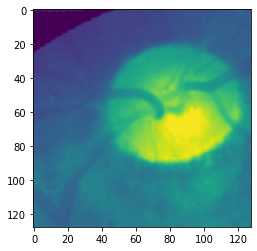

In [ ]:
batch_size = 4
datasets = {'Training': Dataset(os.path.join(ROOT_PATH, 'Training')),
            'Validation': Dataset(os.path.join(ROOT_PATH, 'Validation'), is_train=False)}
dataloaders = {x: DataLoader(datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['Training', 'Validation']}
dataset_sizes = {x: len(datasets[x]) for x in ['Training', 'Validation'] }
n_train = dataset_sizes['Training']
n_val = dataset_sizes['Validation']

print(n_val)
# testing the gt
d = datasets['Training'][0][0]
# print(np.unique(d))
print(d.shape[0])

plt.imshow(d[0])

In [ ]:
# batch_size = 4
# dataset = Dataset(os.path.join(ROOT_PATH, 'Training'))
# n_train = round(len(dataset)*0.85)
# n_val = len(dataset) - n_train
# print(n_train,n_val)
# dataset_sizes = {'Training': n_train, 'Validation': n_val}

# train, val = torch.utils.data.random_split(dataset, [n_train, n_val])
# dataloaders = {'Training': DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=4),
#                'Validation': DataLoader(val, batch_size=batch_size, shuffle=True, num_workers=4)}
# print(len(train))
# plt.imshow(train[0][0][0])

#Unet

In [ ]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
  """(convolution => [BN] => ReLU) * 2"""

  def __init__(self, in_channels, out_channels, mid_channels=None, residual=True):
    super().__init__()
    if not mid_channels:
      mid_channels = out_channels

    self.res_conv = None
    if residual:
      self.res_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
    
    self.double_conv = nn.Sequential(
      nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(mid_channels),
      nn.ReLU(inplace=True),
      # nn.LeakyReLU(negative_slope = 0.01, inplace=True),
      nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True))
      # nn.LeakyReLU(negative_slope = 0.01, inplace=True))
      # nn.Dropout2d(p=0.25)) #TWEAK HYPERPARAMETER P 

  def forward(self, x):
    x_in = x
    x = self.double_conv(x)

    if self.res_conv is not None:
      x = x + self.res_conv(x_in)

    return x


class Down(nn.Module):
  """Downscaling with maxpool then double conv"""

  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.maxpool_conv = nn.Sequential(
      #nn.MaxPool2d(2),
      nn.AvgPool2d(2),
      DoubleConv(in_channels, out_channels))

  def forward(self, x):
    return self.maxpool_conv(x)


class Up(nn.Module):
  """Upscaling then double conv"""

  def __init__(self, in_channels, out_channels, bilinear=True):
    super().__init__()

    # if bilinear, use the normal convolutions to reduce the number of channels
    if bilinear:
      self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
      self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
    else:
      self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
      self.conv = DoubleConv(in_channels, out_channels)


  def forward(self, x1, x2):
    x1 = self.up(x1)
    # # input is CHW
    # diffY = x2.size()[2] - x1.size()[2]
    # diffX = x2.size()[3] - x1.size()[3]

    # x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
    #                 diffY // 2, diffY - diffY // 2])
    # if you have padding issues, see
    # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
    # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
    x = torch.cat([x2, x1], dim=1)
    return self.conv(x)


class OutConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(OutConv, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=5) # try kernel_size to 3 for faster conversions also put padding=1

  def forward(self, x):
    return self.conv(x)

class UNet(nn.Module):
  def __init__(self, n_channels, n_classes, bilinear=True):
    super(UNet, self).__init__()
    self.n_channels = n_channels
    self.n_classes = n_classes
    self.bilinear = bilinear

    self.inc = DoubleConv(n_channels, 64)
    self.down1 = Down(64, 128)
    self.down2 = Down(128, 256)
    self.down3 = Down(256, 512)
    factor = 2 if bilinear else 1
    self.down4 = Down(512, 1024 // factor)
    self.up1 = Up(1024, 512 // factor, bilinear)
    self.up2 = Up(512, 256 // factor, bilinear)
    self.up3 = Up(256, 128 // factor, bilinear)
    self.up4 = Up(128, 64, bilinear)
    # self.outc = OutConv(64, n_classes)
    self.outc = nn.Conv2d(64, n_classes, kernel_size=1, padding = 0) # try kernel_size to 3 for faster conversions also put padding=1

  def forward(self, x):
    x1 = self.inc(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)
    x5 = self.down4(x4)
    x = self.up1(x5, x4)
    x = self.up2(x, x3)
    x = self.up3(x, x2)
    x = self.up4(x, x1)
    logits = self.outc(x)
    return logits

In [ ]:
def one_hot(x, num_classes):
  return F.one_hot(x, num_classes=num_classes).permute(0, 3, 1, 2).float()

def saturate_probabilities(x):
  return one_hot(torch.argmax(x, dim=1), num_classes=x.shape[1])

def dice_metric(prediction, target):
  N, C, H, W = prediction.shape
  spatial_dims = (2, 3)

  prediction = saturate_probabilities(prediction)
  target = one_hot(target.squeeze(1), C)

  overlap = torch.sum(prediction * target, dim=spatial_dims)
  total = torch.sum(target, dim=spatial_dims) + torch.sum(prediction, dim=spatial_dims)

  dice_coeffs = 2 * overlap / total 
  dice_coeffs = torch.mean(dice_coeffs, dim=0)

  return dice_coeffs

In [ ]:
class HybridLogisticDiceLoss3D(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, prediction, target):
    N, C, H, W = prediction.size()
    spatial_dims = (2, 3)

    target = one_hot(target, C)

    overlap = torch.sum(prediction * target, dim=spatial_dims)

    total = torch.sum(target * target, dim=spatial_dims) + torch.sum(prediction * prediction, dim=spatial_dims)

    dice_coeffs = 2 * overlap / total
   
    # small eps to avoid blowing up if the model ever starts getting really confident and predicts a 0.0 score
    # This was happening around epoch 20 for NestedUNet
    eps = 1e-8
    logistic = torch.sum(target * (torch.log(prediction + eps) - eps), dim=spatial_dims) / (H * W)

    hybrid = -logistic - dice_coeffs + 1

    return torch.sum(torch.sum(hybrid, dim=1) / C) / N

In [ ]:
def train_model(model, criterion, optimizer, scheduler, n_epochs = 3):
  start = time.time()
  train_loss_list = []
  valid_loss_list = []
  dice_score_list = []
  lr_rate_list = []
  valid_loss_min = np.Inf # track change in validation loss

  writer = SummaryWriter(log_dir = logs_base_dir)

  for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    dice_score = 0.0
    ###################
    # train the model #
    ###################
    model.train()
    bar = tqdm(dataloaders['Training'], postfix={"train_loss":0.0})
    for data, target in bar:
      # move tensors to GPU if CUDA is available

      data, target = data.to(device), target.to(device)

      # clear the gradients of all optimized variables
      optimizer.zero_grad()
      # forward pass: compute predicted outputs by passing inputs to the model

      output = model(data)

      output = nn.Softmax(dim=1)(output)

      # calculate the batch loss
      loss = criterion(output, target.squeeze(1).type(torch.long))
      
      # backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()
      # perform a single optimization step (parameter update)
      optimizer.step()
      # update training loss
      train_loss += loss.item()*data.size(0)
      bar.set_postfix(ordered_dict={"train_loss":loss.item()})

    ######################    
    # validate the model #
    ######################
    model.eval()
    # del data, target
    with torch.no_grad():
      bar = tqdm(dataloaders['Validation'], postfix={"valid_loss":0.0, "dice_score":0.0})
      for data, target in bar:
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        output = nn.Softmax(dim=1)(output)
        # calculate the batch loss
        loss = criterion(output, target.squeeze(1).type(torch.long))
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)

        # dice_cof = dice_no_threshold(output.cpu(), target.cpu()).item()
        dice_cof = dice_metric(output, target).cpu().numpy()
        dice_score +=  dice_cof * data.size(0)
        bar.set_postfix(ordered_dict={"valid_loss":loss.item(), "dice_score":dice_cof})
    
    # calculate average losses
    train_loss = train_loss/n_train
    valid_loss = valid_loss/n_val
    dice_score = dice_score/n_val
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    dice_score_list.append(dice_score)
    lr_rate_list.append([param_group['lr'] for param_group in optimizer.param_groups])
    
    # print training/validation statistics 
    print('Epoch: {}  Training Loss: {:.6f}  Validation Loss: {:.6f} Dice Score: {}'.format(
        epoch, train_loss, valid_loss, dice_score))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'drive/Shared drives/Capstone Summer 2020/Models/Unet_From_Scratch/model_cifar.pt')
        valid_loss_min = valid_loss
    
    scheduler.step()

  time_elapsed = time.time() - start
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  torch.save(model.state_dict(), 'drive/Shared drives/Capstone Summer 2020/Models/Unet_From_Scratch/Laroy_UNet-Crop.pth')
  return model, train_loss_list, valid_loss_list, dice_score_list, lr_rate_list

##TODO
*change criterion to hybriddiceloss function provided by cory

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = UNet(3,3)
model.to(device)

lr = 0.0004125
weights = [1.0, 1.0, 0.75]
class_weights = torch.FloatTensor(weights).to(device)

# criterion = nn.CrossEntropyLoss()
criterion = HybridLogisticDiceLoss3D()
optimizer = optim.Adam(model.parameters(), lr=lr)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)


In [ ]:
 model, train_loss_list, valid_loss_list, dice_score_list, lr_rate_list = train_model(model, criterion, optimizer, exp_lr_scheduler, n_epochs=2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:918.)
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output channels_last tensor even if some of the inputs are not in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:924.)



Epoch: 1  Training Loss: 0.498048  Validation Loss: 0.409477 Dice Score: [0.36547434 0.5471781  0.9525571 ]
Validation loss decreased (inf --> 0.409477).  Saving model ...



Epoch: 2  Training Loss: 0.442700  Validation Loss: 0.391349 Dice Score: [0.46944323 0.54550755 0.9552465 ]
Validation loss decreased (0.409477 --> 0.391349).  Saving model ...
Training complete in 0m 29s


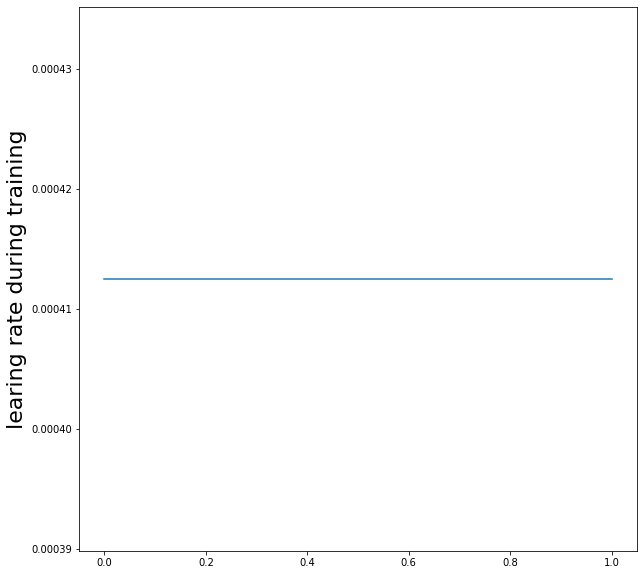

In [ ]:
plt.figure(figsize=(10,10))
plt.plot([i[0] for i in lr_rate_list])
plt.ylabel('learing rate during training', fontsize=22)
plt.show()

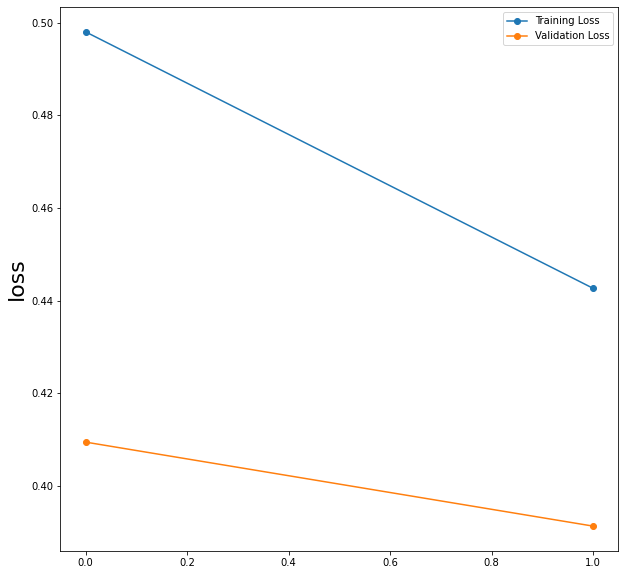

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(train_loss_list,  marker='o', label="Training Loss")
plt.plot(valid_loss_list,  marker='o', label="Validation Loss")
plt.ylabel('loss', fontsize=22)
plt.legend()
plt.show()

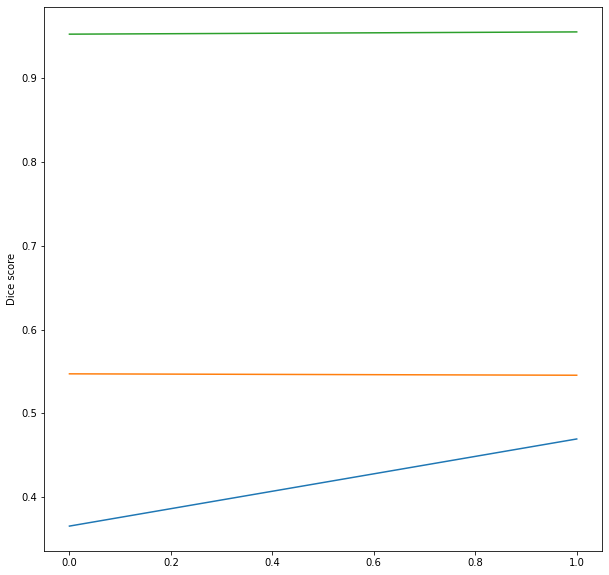

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(dice_score_list)
plt.ylabel('Dice score')
plt.show()

In [ ]:
# load best model
model = UNet(3,3)
model.load_state_dict(torch.load('drive/Shared drives/Capstone Summer 2020/Models/Unet_From_Scratch/Laroy_UNet-Crop.pth')) # this is the final epoch saved
# model.load_state_dict(torch.load('drive/Shared drives/Capstone Summer 2020/Models/Unet_From_Scratch/model_cifar.pt')) # This is the best model saved!
model.eval();

In [ ]:
model.to(device)
# model.load_state_dict(torch.load('drive/Shared drives/Capstone Summer 2020/Models/Unet_From_Scratch/Laroy_UNet-Crop.pth'))

VisModel(model, criterion, optimizer, device, datasets, dataset_sizes)

interactive(children=(Dropdown(description='instance_id', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1…

In [ ]:
def decode_segmap(image, nc=3):
  
  label_colors = np.array([(0, 0, 0), (130, 130, 130), (255, 255, 255)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

UNIQUE MASK: [0 1 2]


Text(0.5, 1.0, 'GT')

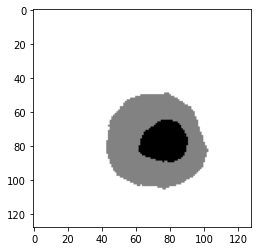

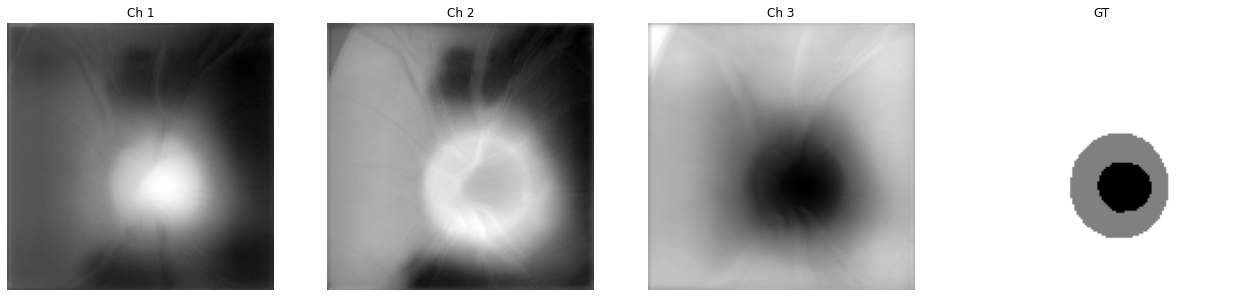

In [ ]:
imageName = "V0001"
folderName= "Validation"

img_path = "drive/Shared drives/Capstone Summer 2020/Data/"+ folderName +"/Images/"+ imageName +".jpg"
img = np.array(Image.open(img_path).convert("RGB").resize((128, 128), resample=Image.NEAREST))

img = torch.from_numpy(Dataset.preprocess(img))
img = img.to(device)
img = img.type(torch.cuda.FloatTensor)
img = img.unsqueeze(0)

img = normalize(img)

mask_path = "drive/Shared drives/Capstone Summer 2020/Data/"+ folderName +"/Masks/"+ imageName +".bmp"
ground_truth = np.array(Image.open(mask_path).resize((128, 128), resample=Image.NEAREST))

ground_truth = Dataset.preprocess(ground_truth)*2

# ground_truth = ground_truth.resize((408, 408), resample=Image.NEAREST)
# ground_truth = fix_mask(np.array(ground_truth))
ground_truth = torch.from_numpy(ground_truth).long()[0]
print("UNIQUE MASK:", np.unique(ground_truth))

with torch.no_grad():
  result = model(img)

mask = torch.argmax(result, dim=1)

mask = mask[0]

full_mask = mask.detach().cpu().numpy()

rgb = decode_segmap(torch.argmax(result.squeeze(), dim=0).detach().cpu().numpy(), nc=3)

plt.imshow(rgb)


#Plotting all predicted masks
ch1_mask = result[0][0].detach().cpu().numpy()
ch2_mask = result[0][1].detach().cpu().numpy()
ch3_mask = result[0][2].detach().cpu().numpy()

fig, axs = plt.subplots(1, 4, figsize=(22,5))


#plot original image
axs[0].imshow((ch1_mask), cmap='gray')
axs[0].axis('off')   
axs[0].set_title('Ch 1')

#plot ground truth
axs[1].imshow((ch2_mask), cmap='gray')
axs[1].axis('off')   
axs[1].set_title('Ch 2')

#plot the mask
axs[2].imshow((ch3_mask), cmap='gray')
axs[2].axis('off')   
axs[2].set_title('Ch 3')

axs[3].imshow((ground_truth), cmap='gray')
axs[3].axis('off')   
axs[3].set_title('GT')


In [ ]:
# img = img.type(torch.cuda.FloatTensor)
print(result.shape, ground_truth.unsqueeze(0).shape)

dice_metric(result, ground_truth.unsqueeze(0).unsqueeze(0).to(device))

torch.Size([1, 3, 128, 128]) torch.Size([1, 128, 128])


tensor([0.8602, 0.7507, 0.9747], device='cuda:0')

[0 1 2]
(128, 128)


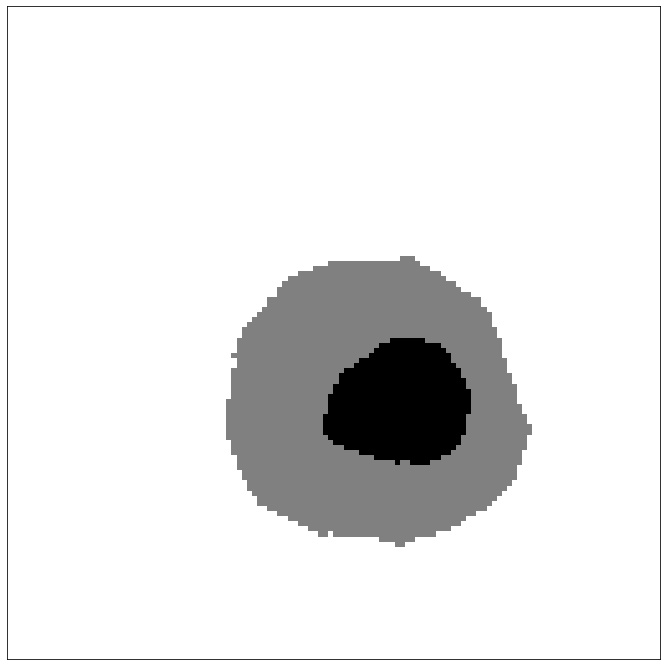

In [ ]:
print(np.unique(full_mask))
print(full_mask.shape)
plt.figure(figsize=(12, 12))
plt.tick_params(which='both', bottom=False, top=False, left=False, labelbottom=False, labelleft=False)
plt.imshow(full_mask, cmap="gray")

In [ ]:
batch_size = 4
dataset = Dataset(os.path.join(ROOT_PATH, 'Testing'))
x1 = round(len(dataset)*0.95)
testing_size = len(dataset) - x1
print('Size of testing:', testing_size)


train, val = torch.utils.data.random_split(dataset, [x1, testing_size])
testing = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=4)

model.eval()

for data, target in testing:
  data = data.to(device)
  target = target.to(device)
  with torch.no_grad():
    output = model(data)
  dice_metric(output, target).cpu().numpy()

Size of testing: 20
